# Week 5 Part 2 Assignment
### DATA 620

David Moste ~ Euclid zhang ~ Samuel Reeves
***
### Problem Description

Can we make a model with Python's Natural Language Toolkit that accurately categorizes real and fake news?

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup

import wordcloud
from wordcloud import WordCloud

### Data Description & Preprocessing
***
Data source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

This set contains just under 50k news items, about 55:45 fake:real.  We have downloaded the set and put in the github repository zipped.  Unzip it and we can begin...

The important steps to transform this human-readable news into clean data are the following:

1. Tokenizing the text bounded by whitespace
2. Removing numbers and special characters (except the period used for abbreviations)
3. Removing hyperlinks and artifacts of html
4. Removing stop words
5. Changing contractions to their long form (eg. he's --> he is)
6. Removing the string "Images." at the end of the text, used to show that there are attached images to an article
7. Lemmatizing the text

In [2]:
fake_news = pd.read_csv(r"Fake.csv", header=0, index_col=False)
real_news = pd.read_csv(r"True.csv", header=0, index_col=False)

fake_news['fake'] = True
real_news['fake'] = False

fake_news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",True


In [3]:
len(fake_news), len(real_news)

(23481, 21417)

There are too many news items! Training this model, even without cross-validation, crashes our machines.

![Crash](crash.png "Crash")

We subset the news items for the type 'politics' and with Trump mentioned somewhere.

In [4]:
fake_news2 = fake_news.loc[fake_news['subject'] == 'politics']
real_news2 = real_news.loc[fake_news['subject'] == 'politics']

fake_news2 = fake_news2.loc[[bool(re.search('[t|T]rump',news)) for news in fake_news2['text']]]
real_news2 = real_news2.loc[[bool(re.search('[t|T]rump',news)) for news in real_news2['text']]]

news = fake_news2[['text','fake']].append(real_news2[['text','fake']], ignore_index = True)

fake_news['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

In [15]:
len(news)

4725

In [5]:
wnl = nltk.WordNetLemmatizer()
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words = stop_words + ['could', 'should','would','']
stop_words.remove('not')

def clean_text(text):
    text = str(text).lower()   
    
    # Remove hyperlinks
    text = re.sub(r'[^\s]+\.com.[^\s]+','',text)
    text = re.sub(r'http[^\s]+','',text)
    
    # Clean the html tags
    text = BeautifulSoup(text).get_text()
    
    # A lot of the news items have the word 'images' at the end to represent that 
    # there are images attached to the news.
    text = re.sub(r'Images\.$', '', text)
    
    # Remove special characters except '.', since it can be used in abbreviations
    text = re.sub(r'[^A-Za-z\s\.]+', ' ', text)  
    # Remove '.' that is not used in abbreviations
    text = re.sub(r'([A-Za-z]{2,})\.', r'\1 ', text)
    
    # Replace multiple spaces by 1 space
    text = re.sub(r'\s{2,}', ' ', text)
       
    # In the text, the ' character is omiited. Therefore, string such as he's is stored as he s
    # The following code coverts such string to its complete form.
    # For example, he'll is coverted into he will
    text = re.sub(r'(he|she|it|this|that) (s )', r'\1 is', text)
    text = re.sub(r'(they|we) (re)', r'\1 are', text)
    text = re.sub(' ve ', ' have ', text)
    text = re.sub(' ll ', ' will ', text)
    text = re.sub('won t ', 'will not ', text)
    text = re.sub('n t ', ' not ', text)
    
    # Stopwords, lemmatizing
    text = [word for word in text.split(' ') if word not in stop_words]
    text = [wnl.lemmatize(word) for word in text]

    text = " ".join(text)
    text = text.strip()
    
    return text

nltk.download('wordnet')
news['cleaned_text'] = news['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /home/s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Documents with only a hyperlink as content will become an empty string after clean up.  We can remove these.

In [6]:
news.loc[[len(news) == 0 for news in news['cleaned_text']]]['text']
news = news.loc[[len(news) != 0 for news in news['cleaned_text']]]
news.reset_index(drop=True, inplace = True)

In [7]:
news

,text,fake,cleaned_text
0,Just one more reminder of why President Trump ...,True,one reminder president trump chose nonsense ge...
1,Thank goodnesss Jeff Sessions is moving on fin...,True,thank goodness jeff session moving finding wen...
2,The GOP presidential candidate who couldn t se...,True,gop presidential candidate not seem find spine...
3,John Podesta is Hillary Clinton s former campa...,True,john podesta hillary clinton former campaign c...
4,EAG News A Wyoming high school is under fire ...,True,eag news wyoming high school fire parent expos...
...,...,...,...
4720,SEOUL (Reuters) - North Korea may be planning ...,False,seoul reuters north korea may planning new mis...
4721,SEOUL/BEIJING (Reuters) - Chinese President Xi...,False,seoul beijing reuters chinese president xi jin...
4722,(Reuters) - The White House admonished Russia ...,False,reuters white house admonished russia wednesda...
4723,HONG KONG (Reuters) - Hong Kong will try to en...,False,hong kong reuters hong kong try enact law pena...


## Analysis
***
Use TfidfVectorizer to calculate the Term Frequency — Inverse Document Frequency of unigram tokens.  This is equivalent to running CountVectorizer followed by TfidfTransformer.  With this *extremely* sparse matrix, we are taking a bag-of-words approach to describing each document.  We can then use these vectors to train our model using a Naive Bayes Classifier.

In [8]:
Tf_Idf_Vectorizer = TfidfVectorizer(ngram_range=(1,1))

X = Tf_Idf_Vectorizer.fit_transform(news['cleaned_text']).toarray()
Y = news['fake']

df_tfidfvect = pd.DataFrame(data = X,columns = Tf_Idf_Vectorizer.get_feature_names())

df_tfidfvect

,aaa,aadl,aapl,aardvark,aarhus,aaron,aaronapollocamp,aarondfordnv,aarp,ab,...,ztqxcz,zucker,zuckerberg,zuckerman,zuckersaid,zuhri,zullo,zuma,zwgrt,zyuganov
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_tfidfvect_real = df_tfidfvect.loc[news['fake'] == False]
df_tfidfvect_fake = df_tfidfvect.loc[news['fake']]

The most important key words mentioned in real news are:

In [10]:
most_important_real = df_tfidfvect_real.sum().sort_values(ascending = False).T.drop("trump")
most_important_real[:20]

said            125.066977
republican       75.329660
state            66.923282
reuters          61.349554
not              51.912283
jerusalem        49.858461
korea            46.622189
cruz             46.268181
north            45.200363
israel           44.525289
presidential     44.326798
president        44.204000
united           44.022380
party            42.725603
clinton          39.596675
campaign         36.392030
palestinian      36.344969
candidate        36.338756
china            35.179194
washington       34.658149
dtype: float64

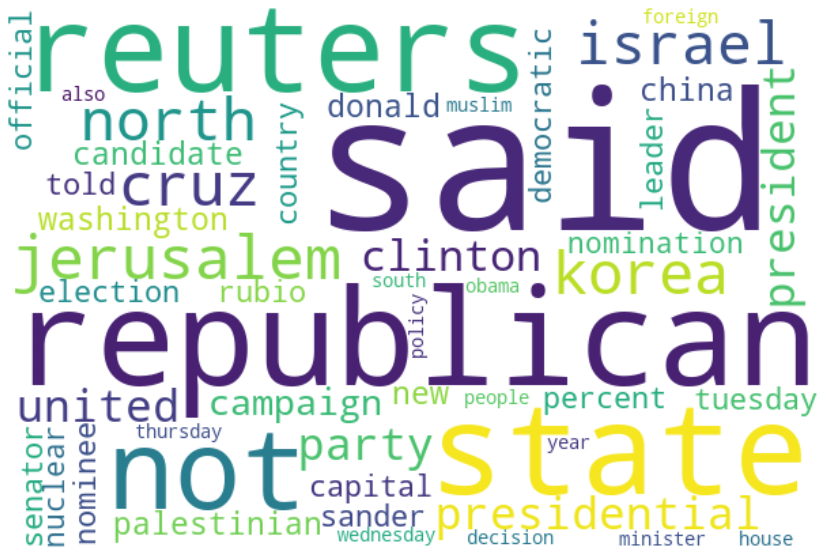

In [11]:
Cloud = WordCloud(width=600, height=400, background_color="white", max_words=50).generate_from_frequencies(most_important_real)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

The most important key words mentioned in fake news are:

In [12]:
most_important_fake = df_tfidfvect_fake.sum().sort_values(ascending = False).T.drop("trump")
most_important_fake[:20]

not           119.574824
president      84.304688
said           67.348982
clinton        67.337964
hillary        62.514930
obama          61.450401
people         55.015592
american       49.434523
donald         48.864368
one            46.684580
news           44.998623
like           42.767282
america        40.824405
say            40.341627
time           40.093884
state          40.056584
medium         39.700133
democrat       39.224259
republican     39.045794
video          38.876305
dtype: float64

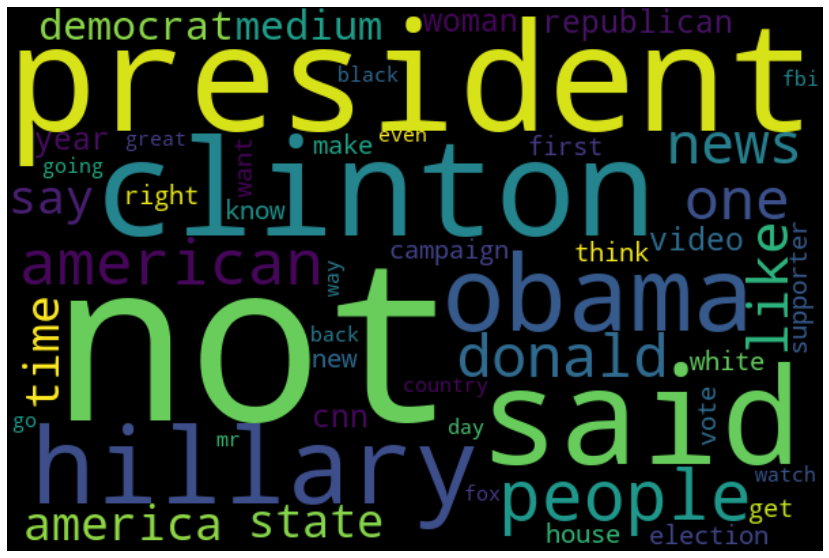

In [13]:
Cloud = WordCloud(width=600, height=400, background_color="black", max_words=50).generate_from_frequencies(most_important_fake)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

It's interesting to see that a lot of key words about real news are about republicans and a lot of key words about fake news are democrats. We suppose that this is because of the subsetting.  Perhaps the opposite would occur if we chose only those news stories with the subject politics and subsetted by the word "Clinton".  It's also interesting to note that "Reuters" is a notably common word in the real news.

Now let's build our model using Multinomial Naive Bayes.

In [14]:
mnb = MultinomialNB()

model_scores = pd.DataFrame(columns = ['accurary','precision','recall','F1',
                                       'True Positive','False Positive','True Negative','False Negative'])
kf = KFold(n_splits=5,random_state=620,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    mnb.fit(X_train, Y_train)
    y_pred = mnb.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, y_pred)
    precision = metrics.precision_score(Y_test, y_pred)
    recall = metrics.recall_score(Y_test, y_pred)
    F1 = metrics.f1_score(Y_test, y_pred)
    cm = metrics.confusion_matrix(Y_test, y_pred)
    cm = cm/cm.astype(float).sum(axis=0)
    model_scores.loc[len(model_scores)] = [accuracy,precision,recall,F1,cm[1, 1],cm[0, 1],cm[0, 0],cm[1, 0]]
    
model_scores.loc['Average'] = model_scores.mean()
model_scores

,accurary,precision,recall,F1,True Positive,False Positive,True Negative,False Negative
0,0.898413,0.872675,0.988655,0.927052,0.872675,0.127325,0.971545,0.028455
1,0.886772,0.855263,0.986509,0.916210,0.855263,0.144737,0.969349,0.030651
2,0.918519,0.894502,0.990132,0.939891,0.894502,0.105498,0.977941,0.022059
3,0.883598,0.855524,0.986928,0.916540,0.855524,0.144476,0.966527,0.033473
4,0.912169,0.901004,0.978193,0.938013,0.901004,0.098996,0.943548,0.056452
Average,0.899894,0.875794,0.986083,0.927541,0.875794,0.124206,0.965782,0.034218


### Scoring
***
The scores indicate that our model is performing well! The accurary is around 90 percent. We have correctly identified 88% of the fake news and 97% of the real news after subsetting for politics and Trump.